In [1]:
from datetime import datetime
import json
from collections import Counter

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
import torchmetrics

from deeprec.torch.trainer import Trainer, set_device
from deeprec import ROOT

In [2]:
with open('../data/metadata.json', 'r') as fp:
    meta = json.load(fp)

meta.keys()

dict_keys(['title_emb_size', 'string_na', 'genres', 'ages', 'occupations', 'user', 'movie', 'city', 'state'])

In [3]:
len(Counter([2, 1, 3]))

3

In [4]:
class Vocab(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, x):
        c = Counter(x)
        self.lookup_ = {
            str(v).lower(): k for k, v in enumerate([x[0] for x in sorted(c.items(), key=lambda x: x[1], reverse=True)])
        }

    def transform(self, x):
        return [self.lookup_.get(str(xx).lower(), len(self.lookup_)+1) for xx in x]

In [5]:
df = pd.read_parquet('../data/train.parq.gzip').drop('rating', axis=1)
df.head()

,user,movie,hour,day_of_week,month,ts,gender,age,occupation,city,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
index,,,,,,,,,,,,,,,,,,,,,
693094,1489,2648,3,5,11,2000-11-25 03:35:14,1,35,2,Evanston,...,0.059832,0.46583,0.774960,0.43321,0.370830,0.140020,0.521110,-0.960430,-0.622770,0.245130
563664,2440,3101,17,1,11,2000-11-14 17:03:49,0,50,17,Ashburnham,...,1.982520,0.84989,1.708770,1.34452,-1.051670,-0.032240,0.662540,-0.448420,-1.197040,-0.698660
192,682,1193,16,3,11,2000-11-30 16:33:10,0,25,4,Carrboro,...,2.176160,2.86298,2.238394,-2.15952,1.210480,-3.436165,-0.329595,3.619880,-2.470530,1.399963
664671,3512,1005,17,0,8,2000-08-28 17:16:19,0,18,17,Cambridge,...,-1.662040,0.99335,-1.184181,1.58626,0.718946,-1.731300,2.357530,1.096584,-2.896070,0.150750
967203,5074,1202,5,5,7,2000-07-01 05:14:36,0,1,0,Purcellville,...,1.998510,1.07155,-0.863230,0.24211,-0.773756,0.235041,1.170840,-2.078201,-1.310696,-0.964250


In [6]:
state_enc = Vocab()
state_enc.fit(df['state'])

city_enc = Vocab()
city_enc.fit(df['city'])

user_enc = Vocab()
user_enc.fit(df['user'])

movie_enc = Vocab()
movie_enc.fit(df['movie'])

In [7]:
df = pd.read_parquet('../data/train.parq.gzip', columns=['rating'])
df.head()

,rating
index,
693094,3
563664,4
192,5
664671,3
967203,5


In [8]:
set(df['rating'])

{1, 2, 3, 4, 5}

In [13]:
class MovieDataset(Dataset):
    def __init__(self, filename, vocabs):
        drop_cols = ['rating', 'ts']
        x = pd.read_parquet(filename).drop(drop_cols, axis=1)
        y = pd.read_parquet(filename, columns=['rating'])

        x['state'] = vocabs['state'].transform(x['state'])
        x['city'] = vocabs['city'].transform(x['city'])
        x['user'] = vocabs['user'].transform(x['user'])
        x['movie'] = vocabs['movie'].transform(x['movie'])

        self.feature_names = x.columns
        self.x = x.to_dict('records')
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [14]:
encoders = {
    'user': user_enc,
    'movie': movie_enc,
    'city': city_enc,
    'state': state_enc
}

train = MovieDataset('../data/train.parq.gzip', vocabs=encoders)
test = MovieDataset('../data/test.parq.gzip', vocabs=encoders)

In [15]:
print(len(train.feature_names))
train.feature_names

54


Index(['user', 'movie', 'hour', 'day_of_week', 'month', 'gender', 'age',
       'occupation', 'city', 'state', 'year', 'genre_action',
       'genre_adventure', 'genre_animation', 'genre_childrens', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_fantasy',
       'genre_filmnoir', 'genre_horror', 'genre_musical', 'genre_mystery',
       'genre_romance', 'genre_scifi', 'genre_thriller', 'genre_war',
       'genre_western', 'embed_0', 'embed_1', 'embed_2', 'embed_3', 'embed_4',
       'embed_5', 'embed_6', 'embed_7', 'embed_8', 'embed_9', 'embed_10',
       'embed_11', 'embed_12', 'embed_13', 'embed_14', 'embed_15', 'embed_16',
       'embed_17', 'embed_18', 'embed_19', 'embed_20', 'embed_21', 'embed_22',
       'embed_23', 'embed_24'],
      dtype='object')

In [16]:
dl = DataLoader(train, 4)
next(iter(dl))

[{'user': tensor([ 406, 5675, 3393,  579]),
  'movie': tensor([ 779,  309,   42, 1741]),
  'hour': tensor([ 3, 17, 16, 17]),
  'day_of_week': tensor([5, 1, 3, 0]),
  'month': tensor([11, 11, 11,  8]),
  'gender': tensor([1, 0, 0, 0]),
  'age': tensor([35, 50, 25, 18]),
  'occupation': tensor([ 2, 17,  4, 17]),
  'city': tensor([  45, 1709, 1107,   12]),
  'state': tensor([ 3,  5, 18,  5]),
  'year': tensor([1931, 1987, 1975, 1996]),
  'genre_action': tensor([0, 0, 0, 0]),
  'genre_adventure': tensor([0, 0, 0, 0]),
  'genre_animation': tensor([0, 0, 0, 0]),
  'genre_childrens': tensor([0, 0, 0, 1]),
  'genre_comedy': tensor([0, 0, 0, 1]),
  'genre_crime': tensor([0, 0, 0, 0]),
  'genre_documentary': tensor([0, 0, 0, 0]),
  'genre_drama': tensor([0, 0, 1, 0]),
  'genre_fantasy': tensor([0, 0, 0, 0]),
  'genre_filmnoir': tensor([0, 0, 0, 0]),
  'genre_horror': tensor([1, 0, 0, 0]),
  'genre_musical': tensor([0, 0, 0, 0]),
  'genre_mystery': tensor([0, 0, 0, 0]),
  'genre_romance': tensor(

In [17]:
z = next(iter(dl))

In [18]:
def stack_features(inputs, feat):
    return torch.stack([v for k, v in inputs.items() if feat in k], 1)


stack_features(z[0], 'genre')

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [23]:
class RecModel(nn.Module):
    def __init__(self, metadata, n_features=54):
        super().__init__()
        self.meta = metadata
        self.embed_dims = {
            'large': 25,
            'med': 7,
            'small': 3
        }
        self.loss_func = nn.MSELoss()

        self.user_embeds = nn.Embedding(
            num_embeddings=len(user_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.city_embeds = nn.Embedding(
            num_embeddings=len(city_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['med']
        )

        self.state_embeds = nn.Embedding(
            num_embeddings=len(state_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['small']
        )

        self.age_embeds = nn.Embedding(
            num_embeddings=max(meta['ages']) + 1,
            embedding_dim=self.embed_dims['small']
        )

        self.occ_embeds = nn.Embedding(
            num_embeddings=max(meta['occupations']) + 1,
            embedding_dim=self.embed_dims['small']
        )

        self.user_model = nn.Sequential(
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU()
        )

        self.movie_embeds = nn.Embedding(
            num_embeddings=len(movie_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.title_embeds = nn.Sequential(
            nn.Linear(in_features=25, out_features=25),
            nn.Softmax()
        )

        self.movie_model = nn.Sequential(
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU()
        )

        self.model = nn.Sequential(
            nn.LazyLinear(out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        x_user = torch.concat(
            (
                self.user_embeds(x['user']),
                self.city_embeds(x['city']),
                self.state_embeds(x['state']),
                self.age_embeds(x['age']),
                self.occ_embeds(x['occupation']),
                x['gender'].unsqueeze(-1),
                x['hour'].unsqueeze(-1),
                x['day_of_week'].unsqueeze(-1),
                x['month'].unsqueeze(-1)
            ),
            dim=1
        )

        x_movie = torch.concat(
            (
                self.movie_embeds(x['movie']),
                self.title_embeds(stack_features(x, 'embed').float()),
                stack_features(x, 'genre'),
                x['year'].unsqueeze(-1)
            ),
            dim=1
        )
        user_block = self.user_model(x_user)
        movie_block = self.movie_model(x_movie.float())
        x = self.model(torch.mul(user_block, movie_block))
        return x

    def predict(self, x):
        return self(x)

In [25]:
NOW = datetime.now().strftime('%Y%m%d-%H%M')
LOG_DIR = ROOT.joinpath('runs', NOW)
BATCH = 2500

train_loader = DataLoader(train, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH)

device = set_device()
mod = RecModel(metadata=meta)
opt = torch.optim.AdamW(mod.parameters(), lr=0.001)
trainer = Trainer(
    mod, epochs=15, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model.pt'),
    optimizer=opt, score_funcs={'mse': torchmetrics.MeanSquaredError()}
)
trainer.fit(train_loader, test_loader, verbose=True)

Batch:   0%|          | 0/361 [00:00<?, ?it/s]/Users/christophersantiago/miniforge3/envs/deeprec/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

Batch: 100%|██████████| 361/361 [00:37<00:00,  8.60it/s]
                                                        
Epoch:   7%|▋         | 1/15 [00:39<09:08, 39.15s/it] 

defaultdict(<class 'list'>, {'epoch': [0], 'train_loss': [1.56156259527497], 'train_mse': [1.4199767112731934], 'valid_loss': [1.168109745514102], 'valid_mse': [1.1604257822036743]})



Batch: 100%|█████████▉| 360/361 [00:29<00:00, 14.58it/s]
                                                        
Epoch:  13%|█▎        | 2/15 [01:10<07:30, 34.67s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1], 'train_loss': [1.56156259527497, 0.9801540046187319], 'train_mse': [1.4199767112731934, 0.9742137789726257], 'valid_loss': [1.168109745514102, 0.9468434104105321], 'valid_mse': [1.1604257822036743, 0.9385048151016235]})



Batch: 100%|██████████| 361/361 [00:30<00:00, 14.98it/s]
                                                        
Epoch:  20%|██        | 3/15 [01:42<06:40, 33.34s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472]})



Batch: 100%|█████████▉| 360/361 [00:29<00:00, 15.52it/s]
                                                        
Epoch:  27%|██▋       | 4/15 [02:13<05:57, 32.49s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075]})



Batch: 100%|██████████| 361/361 [00:28<00:00, 13.35it/s]
                                                        
Epoch:  33%|███▎      | 5/15 [02:44<05:19, 31.98s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075, 0.8335368037223816]})



Batch: 100%|█████████▉| 360/361 [00:27<00:00, 12.42it/s]
                                                        
Epoch:  40%|████      | 6/15 [03:15<04:43, 31.46s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075, 0.8335368037223816, 0.826057493686676]})



Batch: 100%|█████████▉| 360/361 [00:29<00:00,  8.97it/s]
                                                        
Epoch:  47%|████▋     | 7/15 [03:46<04:11, 31.39s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401, 0.819947690019317], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192, 0.8152528405189514], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312, 0.8390331006631618], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075, 0.8335368037223816, 0.826057493686676, 0.8275118470191956]})



Batch: 100%|██████████| 361/361 [00:28<00:00, 14.11it/s]
                                                        
Epoch:  53%|█████▎    | 8/15 [04:16<03:37, 31.14s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401, 0.819947690019317, 0.8135093757650529], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192, 0.8152528405189514, 0.8084497451782227], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312, 0.8390331006631618, 0.8363288611900516], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075, 0.8335368037223816, 0.826057493686676, 0.8275118470191956, 0.8246946930885315]})



Batch: 100%|██████████| 361/361 [00:29<00:00, 15.50it/s]
                                                        
Epoch:  60%|██████    | 9/15 [04:48<03:07, 31.19s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401, 0.819947690019317, 0.8135093757650529, 0.8107133274923731], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192, 0.8152528405189514, 0.8084497451782227, 0.8060430884361267], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312, 0.8390331006631618, 0.8363288611900516, 0.8587064292372727], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075, 0.8335368037223816, 0.826057493686676, 0.8275118470191956, 0.8246946930885315, 0.8481320738792419]})



Batch: 100%|█████████▉| 360/361 [00:28<00:00, 15.16it/s]
                                                        
Epoch:  67%|██████▋   | 10/15 [05:19<02:35, 31.04s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401, 0.819947690019317, 0.8135093757650529, 0.8107133274923731, 0.8076179070485926], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192, 0.8152528405189514, 0.8084497451782227, 0.8060430884361267, 0.8025763630867004], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312, 0.8390331006631618, 0.8363288611900516, 0.8587064292372727, 0.8675693796902169], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075, 0.8335368037223816, 0.826057493686676, 0.8275118470191956, 0.8246946930885315, 0.8481320738792419, 0.8576962947845459]})



Batch: 100%|█████████▉| 360/361 [00:29<00:00, 14.98it/s]
                                                        
Epoch:  73%|███████▎  | 11/15 [05:50<02:04, 31.10s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401, 0.819947690019317, 0.8135093757650529, 0.8107133274923731, 0.8076179070485926, 0.8093179320694667], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192, 0.8152528405189514, 0.8084497451782227, 0.8060430884361267, 0.8025763630867004, 0.8035048842430115], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312, 0.8390331006631618, 0.8363288611900516, 0.8587064292372727, 0.8675693796902169, 0.8280712220726943], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075, 0.8335368037223816, 0.826057493686676, 0.8275118470191956, 0.8246946930885315, 0.8481320738792419, 0.8576962947845459, 0.81503510475


Batch: 100%|█████████▉| 360/361 [00:32<00:00, 10.01it/s]
                                                        
Epoch:  80%|████████  | 12/15 [06:24<01:36, 32.01s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401, 0.819947690019317, 0.8135093757650529, 0.8107133274923731, 0.8076179070485926, 0.8093179320694667, 0.8024976408712752], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192, 0.8152528405189514, 0.8084497451782227, 0.8060430884361267, 0.8025763630867004, 0.8035048842430115, 0.7972615957260132], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312, 0.8390331006631618, 0.8363288611900516, 0.8587064292372727, 0.8675693796902169, 0.8280712220726943, 0.852048933506012], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075, 0.8335368037223816, 0.826057493686676, 0.8275118470191956, 0.82469469


Batch: 100%|██████████| 361/361 [00:31<00:00, 13.35it/s]
                                                        
Epoch:  87%|████████▋ | 13/15 [06:57<01:04, 32.25s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401, 0.819947690019317, 0.8135093757650529, 0.8107133274923731, 0.8076179070485926, 0.8093179320694667, 0.8024976408712752, 0.801415584259086], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192, 0.8152528405189514, 0.8084497451782227, 0.8060430884361267, 0.8025763630867004, 0.8035048842430115, 0.7972615957260132, 0.7960208654403687], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312, 0.8390331006631618, 0.8363288611900516, 0.8587064292372727, 0.8675693796902169, 0.8280712220726943, 0.852048933506012, 0.830608977050316], 'valid_mse': [1.1604257822036743, 0.9385048151016235, 0.8592974543571472, 0.8435012102127075, 0.83353


Batch: 100%|██████████| 361/361 [00:29<00:00, 12.37it/s]
                                                        
Epoch:  93%|█████████▎| 14/15 [07:28<00:31, 31.94s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401, 0.819947690019317, 0.8135093757650529, 0.8107133274923731, 0.8076179070485926, 0.8093179320694667, 0.8024976408712752, 0.801415584259086, 0.7967389965651769], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192, 0.8152528405189514, 0.8084497451782227, 0.8060430884361267, 0.8025763630867004, 0.8035048842430115, 0.7972615957260132, 0.7960208654403687, 0.7913013100624084], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312, 0.8390331006631618, 0.8363288611900516, 0.8587064292372727, 0.8675693796902169, 0.8280712220726943, 0.852048933506012, 0.830608977050316, 0.8234905004501343], 'valid_mse': [1.1604257822036743, 0.9


Batch: 100%|██████████| 361/361 [00:29<00:00, 14.41it/s]
                                                        
Epoch: 100%|██████████| 15/15 [07:58<00:00, 31.93s/it]


defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'train_loss': [1.56156259527497, 0.9801540046187319, 0.8841713954206979, 0.8462289556902202, 0.8354363999538474, 0.8231233429380401, 0.819947690019317, 0.8135093757650529, 0.8107133274923731, 0.8076179070485926, 0.8093179320694667, 0.8024976408712752, 0.801415584259086, 0.7967389965651769, 0.7960652771748995], 'train_mse': [1.4199767112731934, 0.9742137789726257, 0.8781172633171082, 0.841219961643219, 0.8300032019615173, 0.8184989094734192, 0.8152528405189514, 0.8084497451782227, 0.8060430884361267, 0.8025763630867004, 0.8035048842430115, 0.7972615957260132, 0.7960208654403687, 0.7913013100624084, 0.7906312942504883], 'valid_loss': [1.168109745514102, 0.9468434104105321, 0.8677191254569263, 0.8514231603320052, 0.842414033122179, 0.835996241104312, 0.8390331006631618, 0.8363288611900516, 0.8587064292372727, 0.8675693796902169, 0.8280712220726943, 0.852048933506012, 0.830608977050316, 0.823490500450

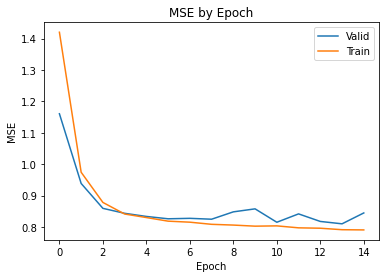

In [26]:
import matplotlib.pyplot as plt

plt.plot(trainer.results['valid_mse'], label='Valid')
plt.plot(trainer.results['train_mse'], label='Train')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE by Epoch')
plt.show()

In [27]:
{e:v for e,v in enumerate(torch.sqrt(torch.tensor(trainer.results['valid_mse'])))}

{0: tensor(1.0772),
 1: tensor(0.9688),
 2: tensor(0.9270),
 3: tensor(0.9184),
 4: tensor(0.9130),
 5: tensor(0.9089),
 6: tensor(0.9097),
 7: tensor(0.9081),
 8: tensor(0.9209),
 9: tensor(0.9261),
 10: tensor(0.9028),
 11: tensor(0.9174),
 12: tensor(0.9042),
 13: tensor(0.9000),
 14: tensor(0.9191)}

<hr>

# DEBUGGING

In [ ]:
dl = DataLoader(train, 32)
z = next(iter(dl))
z

In [ ]:
user_embeds = nn.Embedding(
    num_embeddings=max(meta['occupations'])+1,
    embedding_dim=25
)

In [ ]:
user_embeds(z[0]['occupation']).shape

In [ ]:
z[0]['gender'].dtype

In [ ]:
stack_features(z[0], 'genre').float()

In [ ]:
meta['movie']